In [145]:
import os
import zipfile
import json
import pandas as pd
import math
import rioxarray
import geopandas
import seaborn as sns

## Gather data from floods

Each flood event in flood database consists of flood levels in a tif file and associated metadata in a json file.

Flood data is downloadable with instructions from https://github.com/cloudtostreet/MODIS_GlobalFloodDatabase or as individual flood files from https://global-flood-database.cloudtostreet.ai/.

In [113]:
flood_db_path = 'flood_db\\gfd_v1_4'

def load_flood_properties(file):
    '''Loads properties and bounding box coordinates for a flood event from flood db'''
    with zipfile.ZipFile(file) as z:
        json_file = [file_name for file_name in z.namelist() if file_name.endswith('.json')]
        with z.open(json_file[0]) as f:
            data = f.read()
            properties = json.loads(data)
            properties['fname'] = file

        tif_file = [file_name for file_name in z.namelist() if file_name.endswith('.tif')]
        # Extract tif files for processing
        # Some flood may contain multiple tifs, read only first
        z.extract(tif_file[0], 'temp')
        with rioxarray.open_rasterio('temp/' + tif_file[0]).squeeze() as data:
            properties['xmin'] = data.coords['x'].min().values
            properties['xmax'] = data.coords['x'].max().values
            properties['ymin'] = data.coords['y'].min().values
            properties['ymax'] = data.coords['y'].max().values

    return(properties)

In [114]:
properties_list = [load_flood_properties(flood_db_path + '\\' + fname) for fname in os.listdir(flood_db_path)]
floods_df = pd.DataFrame(properties_list)
floods_df.to_csv('floods.tsv', sep = '\t')

## Estimate probability of capturing a flood

Satellite on a polar orbit has a change of flying over a area that is tied to circumference of earth at the events latitude.

A flood event is considered captured by satellite if floods centroid coordinates were within satellites swath width.

Capture probability is calculated per cycle and probability each cycle is considered independent of each other. This seems appropriate as
- We are considering a short time frame 24h even if given enough orbits satellite would deterministically scan any area.
- Flood widths are small compared to distances between scans of consecutive orbits.

In [115]:
R = 6371
cycle_days = 12
orbits_per_cycle = 175

def radius_at_lat(lat):
    return math.sin(math.pi/2 - math.radians(lat)) * R

def circumference_at_lat(lat):
    r = radius_at_lat(lat)
    return 2*math.pi*r

def prob_per_orbit(lat, swath_width, flood_width=0):
    circ = circumference_at_lat(lat)
    if (circ == 0):
        return(1)
    if (swath_width + flood_width > circumference_at_lat(lat)):
        return(1)

    return (swath_width + flood_width) / circumference_at_lat(lat)

def prob_per_timeframe(lat, swath_width, flood_width=0, time=24):
    p = prob_per_orbit(lat, swath_width, flood_width)
    orbits = orbits_per_cycle / cycle_days * 24 / time
    return(1-pow(1-p, orbits))

In [116]:
swath_width = 400
floods_df['capture_p_in_24h'] = floods_df.apply(lambda x: prob_per_timeframe(x['dfo_centroid_y'], swath_width), axis=1)
floods_df.to_csv('floods_df.tsv', sep = '\t')

In [ ]:
## Features

Calculate flood sizes from bounding box and derive new variables from existing properties.

In [117]:
# Some issue using projection where distances are better calculated.
# Lat lon distances could still be useful for our model
ll = geopandas.points_from_xy(x=floods_df['xmin'], y=floods_df['ymin'], crs=4326)#.to_crs(1029)
ul = geopandas.points_from_xy(x=floods_df['xmin'], y=floods_df['ymax'], crs=4326)#.to_crs(1029)
ur = geopandas.points_from_xy(x=floods_df['xmax'], y=floods_df['ymax'], crs=4326)#.to_crs(1029)

floods_df['flood_width'] = ul.distance(ur)
floods_df['flood_height'] = ll.distance(ul)
floods_df['flood_area'] = floods_df['flood_width'] * floods_df['flood_height']

c:\Users\ville.koponen\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3308: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\Users\ville.koponen\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3308: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [118]:
floods_df['n_countries_affected'] = floods_df.apply(lambda x: len(x['gfd_country_name'].split(',')), axis=1)
floods_df['n_causes'] = floods_df.apply(lambda x: len(x['dfo_main_cause'].split(',')), axis=1)

def deduct_main_cause(causes):
    '''Collate typical flood causes and spellings '''
    if 'dam' in causes.lower():
        return 'dam'
    if ('storm' in causes.lower() or
        'stom' in causes.lower() or
        'strom' in causes.lower() or
        'cyclone' in causes.lower()):
        return 'storm'
    if 'rain' in causes.lower():
        return 'rain'
    if 'tsunami' in causes.lower():
        return 'tsunami'
    if 'snow' in causes.lower() or 'ice' in causes.lower():
        return 'snow'
    return 'other'

floods_df['main_cause'] = floods_df.apply(lambda x: deduct_main_cause(x['dfo_main_cause']), axis=1)
floods_df.to_csv('floods_df.tsv', sep = '\t')


In [166]:
columns=['capture_p_in_24h', 'dfo_centroid_y', 'dfo_centroid_x', 'flood_width','flood_height', 'flood_area', 'dfo_severity', 'n_countries_affected', 'dfo_displaced', 'dfo_dead']

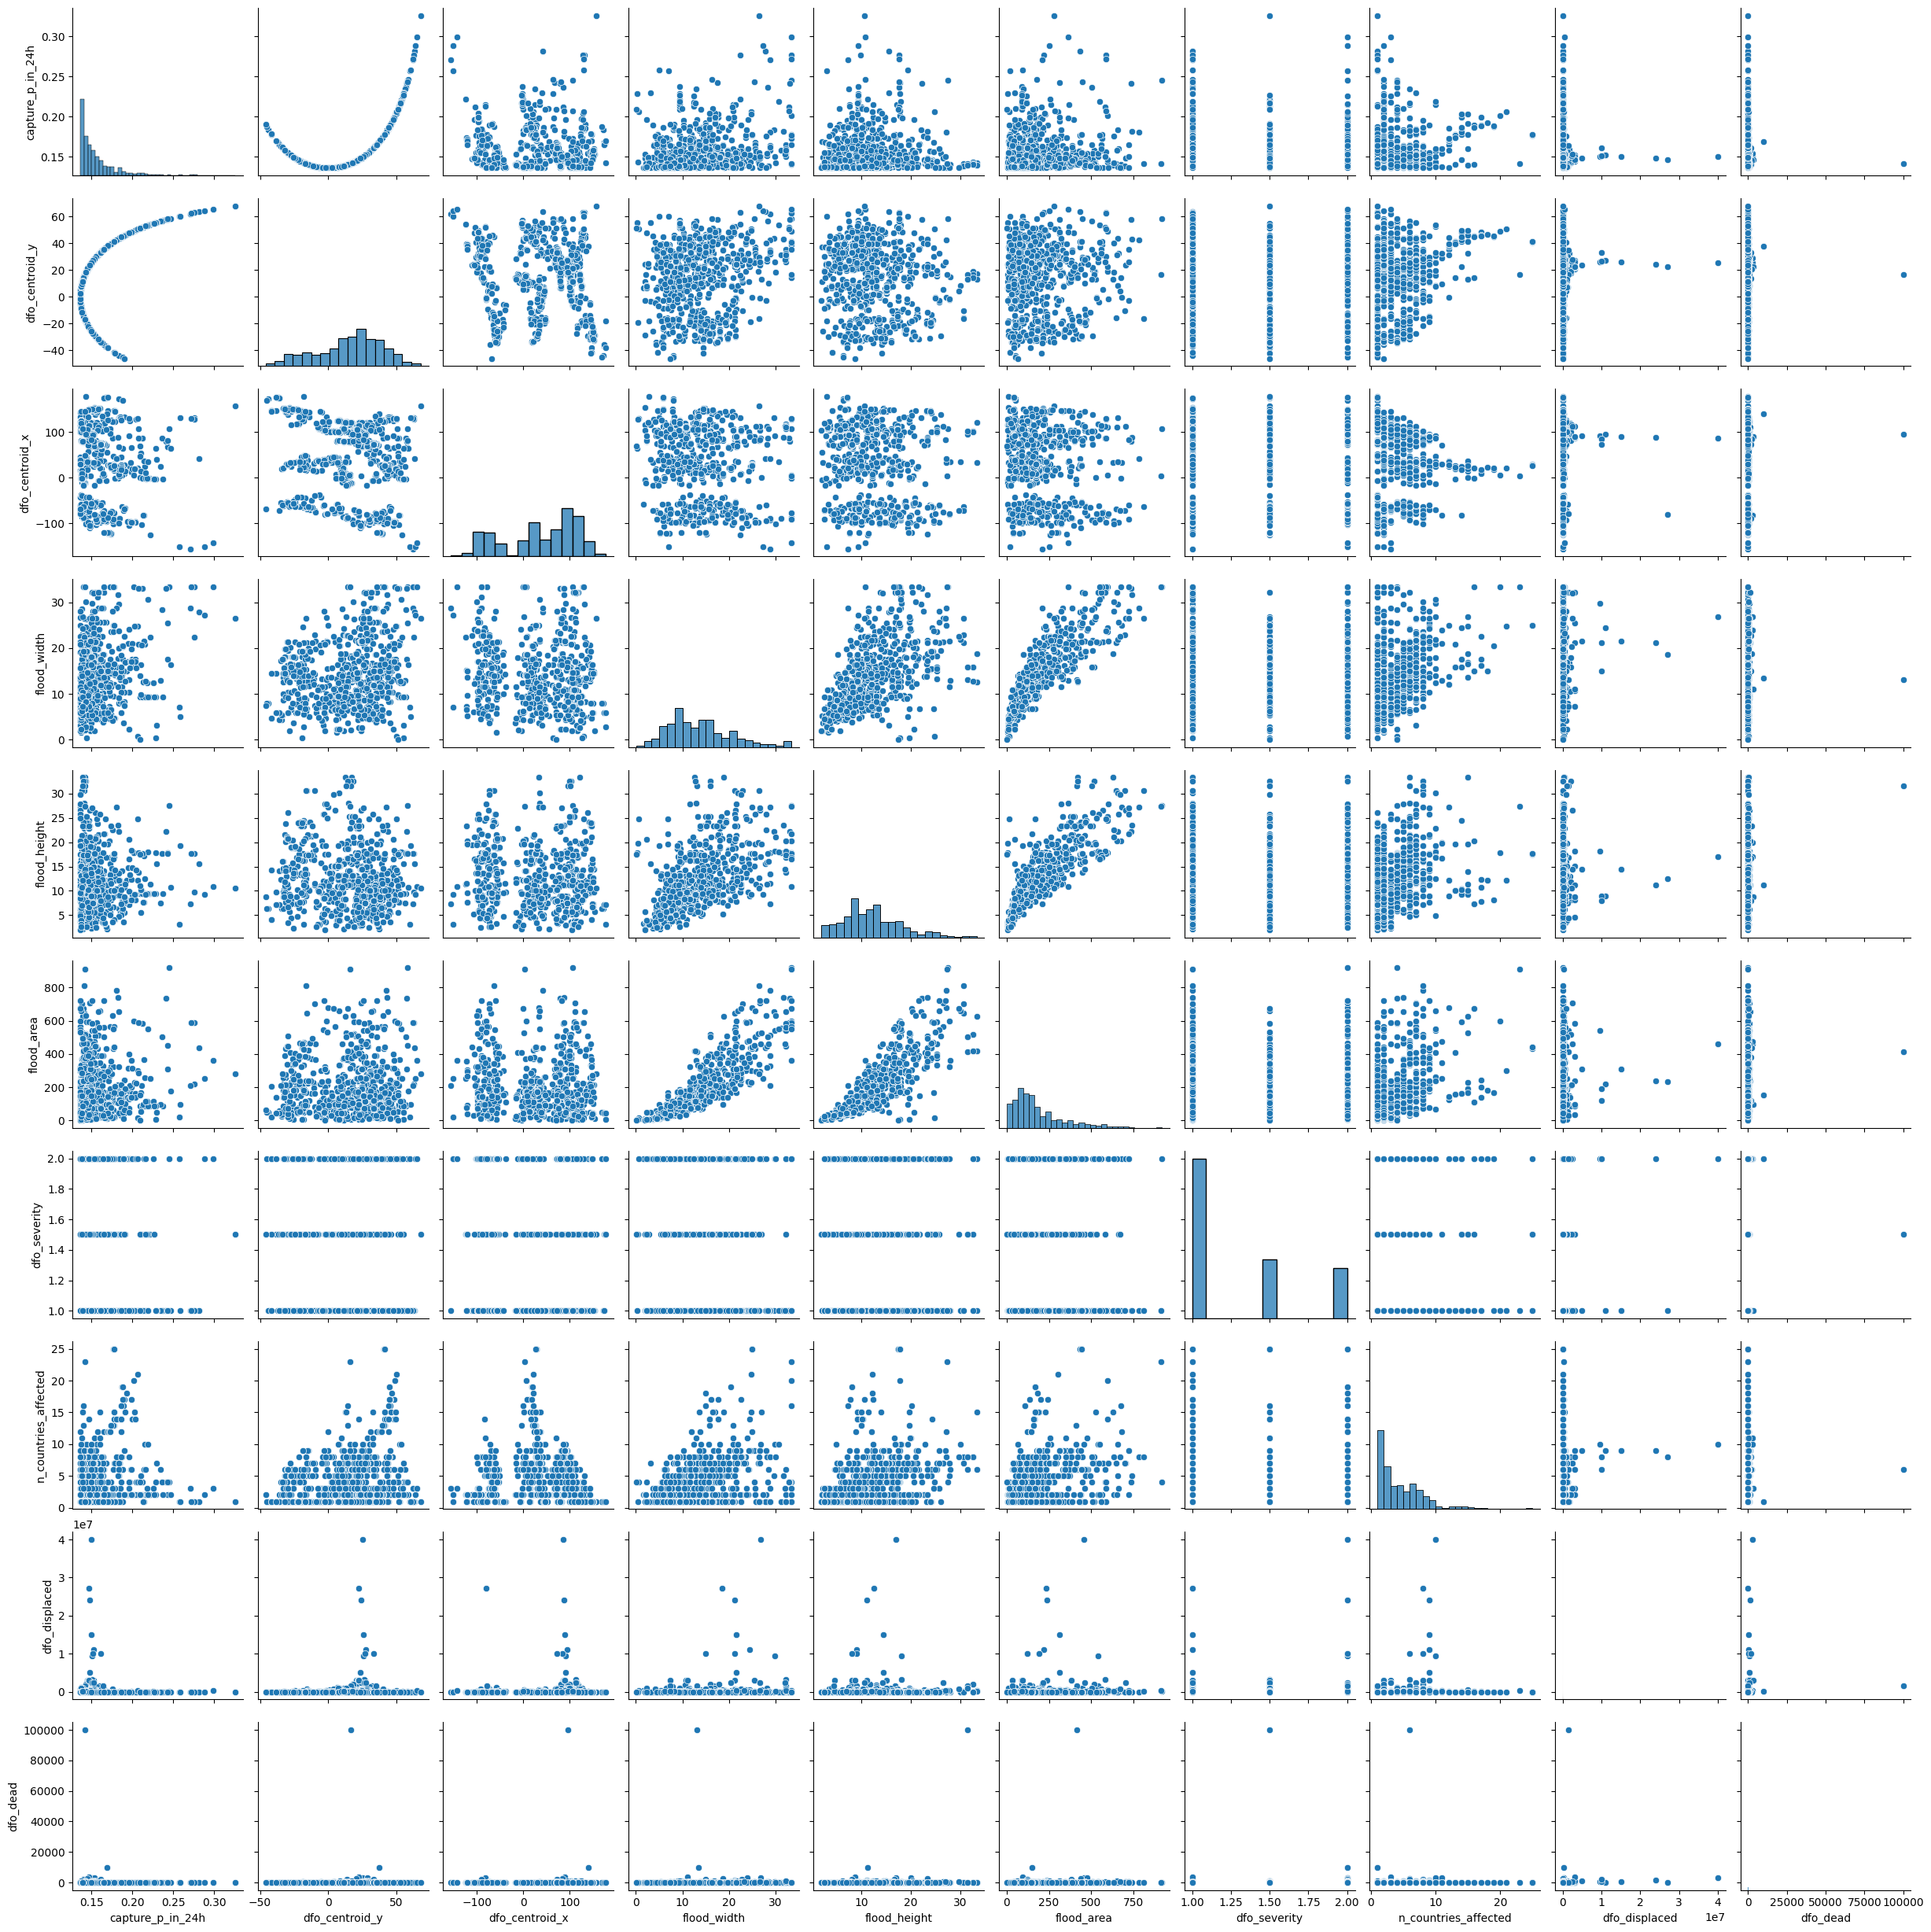

In [175]:
sns.pairplot(floods_df.filter(columns));

<Axes: >

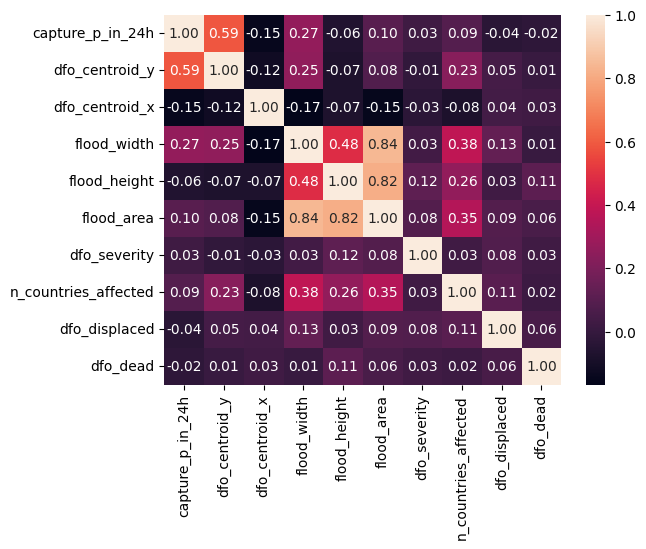

In [167]:
sns.heatmap(floods_df.filter(columns).corr(), annot = True, fmt = '.2f')

<Axes: xlabel='capture_p_in_24h', ylabel='main_cause'>

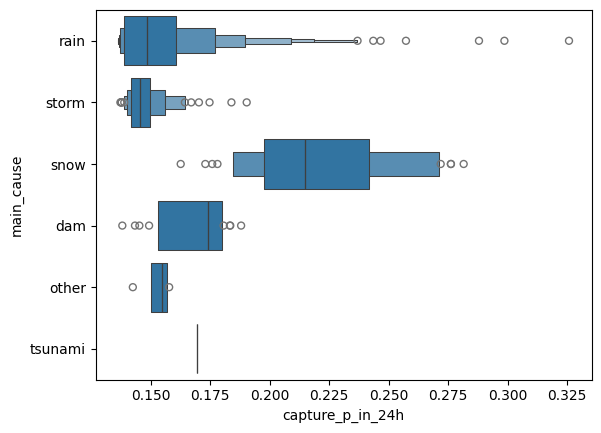

In [176]:
sns.boxenplot(data=floods_df, x="capture_p_in_24h", y="main_cause")

In [181]:
floods_df["dfo_country"].unique()
big_countries = floods_df.loc[floods_df["dfo_country"].isin(['Australia', 'China', 'Russia', 'USA', 'Germany', 'France', 'Brazil', 'Japan', 'United Kingdom'])]

<Axes: xlabel='capture_p_in_24h', ylabel='dfo_country'>

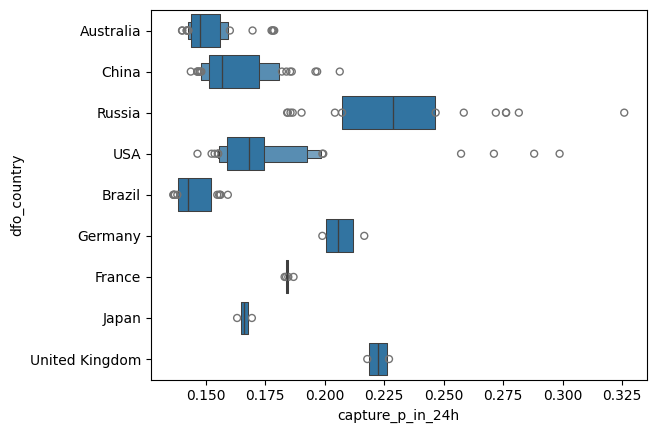

In [182]:
sns.boxenplot(data=big_countries, x="capture_p_in_24h", y="dfo_country")

In [ ]:
Observations from plots:
- Capture probability was generated from latitude coordinate and exhibits a clear non-linear relationship with it.
- Rest of the features have small correlations with capture probability.
- Size related features are strongly correlated.
- Latitude affects capture probability
    - Floods caused by snow are more common in high latitudes and caused by (tropical) storms are more common in lower.
    - Floods are more likely to be caught in countries in lower latitudes.